In [ ]:
%env WORKDIR=/tmp/vault
%env CERT_NAME=2025

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv("/tmp/vault/config.env")

VAULT_TOKEN = os.getenv('VAULT_TOKEN')
VAULT_ADDR = os.getenv('VAULT_ADDR')
VAULT_CACERT = os.getenv('VAULT_CACERT')

## https://developer.hashicorp.com/vault/tutorials/secrets-management/pki-engine

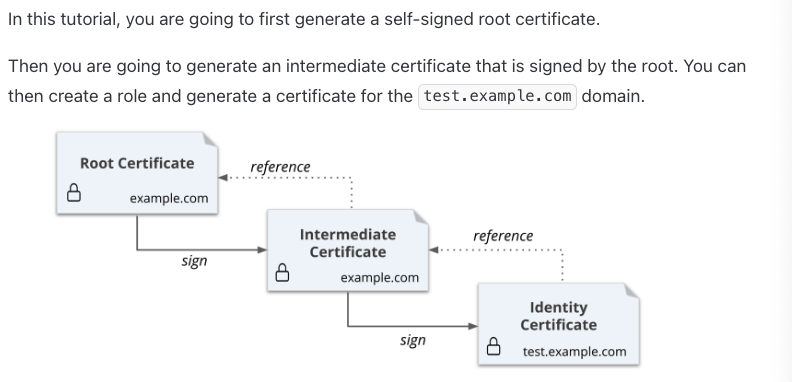

In [ ]:
! curl -k --header "X-Vault-Token: $VAULT_TOKEN" --request POST --data '{"hmac":false}' $VAULT_ADDR/v1/sys/config/auditing/request-headers/my-header

## Step 1: Generate root CA

### Enable PKI engine==mount point

In [ ]:
! vault secrets enable pki 

In [ ]:
# Tune PKI to set max_tll
! vault secrets tune -max-lease-ttl=87600h pki

### Generate rootCA

In [ ]:
%%bash

vault write -field=certificate pki/root/generate/internal \
     common_name="example.com" alt_names="test.com" \
     issuer_name="root-$CERT_NAME" \
     ttl=87600h > ${WORKDIR}/root_$CERT_NAME_ca.crt

### # List CA information

In [ ]:
%%bash
# List CA information
export ISSUER=$(vault list -format=json pki/issuers/ | jq -r .[0])
echo $ISSUER

vault read pki/issuer/$ISSUER | tail -n 11

[PKI Role](https://developer.hashicorp.com/vault/api-docs/secret/pki#create-update-role) details

In [ ]:
%%bash
# Create a role that will allow for using certificates (in this case any name will be valid)
vault write pki/roles/$CERT_NAME-servers allow_any_name=true no_store=false

### Configure CA and CRL URLs

In [ ]:
%%bash
# Configure Vault cluster URLs
vault write pki/config/cluster \
   path=https://vault.vault.svc.cluster.local:8200/v1/pki \
   aia_path=https://vault.vault.svc.cluster.local:8200/v1/pki

In [ ]:
%%bash

vault write pki/config/urls \
   issuing_certificates={{cluster_aia_path}}/issuer/{{issuer_id}}/der \
   crl_distribution_points={{cluster_aia_path}}/issuer/{{issuer_id}}/crl/der \
   ocsp_servers={{cluster_path}}/ocsp \
   enable_templating=true

[OCSP](https://developer.hashicorp.com/vault/api-docs/secret/pki#ocsp-request)

## Step 2: Generate intermediate CA

### The intermediate CA is expressed a another PKI engine with a separate mount point

In [ ]:
! vault secrets enable -path=pki_int pki

In [ ]:
# the mount is configured with a max_tll
! vault secrets tune -max-lease-ttl=43800h pki_int

### Generate Intermediate CA whose CSR is going to be signed by the root CA at pki mount path

In [ ]:
%%bash

vault write -format=json pki_int/intermediate/generate/internal \
     common_name="example.com Intermediate Authority" \
     issuer_name="example-dot-com-intermediate" \
     | jq -r '.data.csr' > $WORKDIR/pki_intermediate.csr

### Send intermediateCA CSR for signing with CA mount point

In [ ]:
%%bash

vault write -format=json pki/root/sign-intermediate \
     issuer_ref="root-$CERT_NAME" \
     csr=@$WORKDIR/pki_intermediate.csr \
     format=pem_bundle ttl="43800h" \
     | jq -r '.data.certificate' > ${WORKDIR}/intermediate.cert.pem

### Import signed intermediate CA (`intermediate.cer.pem`) to its correspondant mount point

In [ ]:
# Import signed intermediate CA to its correspondant mount point
! vault write pki_int/intermediate/set-signed certificate=@${WORKDIR}/intermediate.cert.pem

### Configure CA and CRL URLs for intermediate CA

In [ ]:
%%bash
# Configure Vault cluster URLs
vault write pki_int/config/cluster \
   path=https://vault.vault.svc.cluster.local:8200/v1/pki_int \
   aia_path=https://vault.vault.svc.cluster.local:8200/v1/pki_int

In [ ]:
%%bash
vault write pki_int/config/urls \
   issuing_certificates={{cluster_aia_path}}/issuer/{{issuer_id}}/der \
   crl_distribution_points={{cluster_aia_path}}/issuer/{{issuer_id}}/crl/der \
   ocsp_servers={{cluster_path}}/ocsp \
   enable_templating=true

## Step 3: Create role -> https://developer.hashicorp.com/vault/tutorials/secrets-management/pki-engine#step-3-create-a-role

### Create role that allow certificates to be signed for domain `example.com` and `test.com` with intermediate CA (`pki_int` mount point)

In [ ]:
%%bash
# Create role that allow certificates to be signed for domain `example.com` and `test.com`
vault write pki_int/roles/example-dot-com \
     issuer_ref="$(vault read -field=default pki_int/config/issuers)" \
     allowed_domains="example.com","test.com" \
     allow_subdomains=true \
     allow_glob_domains=true \
     allow_wildcard_certificates=true \
     allow_ip_sans=true \
     allowed_uri_sans="*.example.com" \
     max_ttl="24h" \
     ttl="12h" \
     ext_key_usage="Client Auth"

## Step 4: Requests certificates

### Generate Certificates using Vault CLI

In [ ]:
! vault write pki_int/issue/example-dot-com common_name="*.test.com" ip_sans="8.8.8.9" \
uri_sans="otrauri.example.com,masuri.example.com" ttl="1m" 

### if you want to see details on the audit logs about the certificate information unhash

In [ ]:
%%bash

# Tune to unhash request and response values
vault secrets tune  \
     -max-lease-ttl="43800h"  -audit-non-hmac-request-keys="csr" -audit-non-hmac-request-keys="certificate" -audit-non-hmac-request-keys=issuer_ref -audit-non-hmac-request-keys="common_name" -audit-non-hmac-request-keys=alt_names -audit-non-hmac-request-keys=other_sans  \
     -audit-non-hmac-request-keys="ip_sans" -audit-non-hmac-request-keys=uri_sans  -audit-non-hmac-request-keys=ttl  -audit-non-hmac-request-keys=not_after  \
     -audit-non-hmac-request-keys=serial_number -audit-non-hmac-request-keys=key_type -audit-non-hmac-request-keys=private_key_format \
     -audit-non-hmac-request-keys=ou -audit-non-hmac-request-keys=organization -audit-non-hmac-request-keys=country \
     -audit-non-hmac-request-keys=locality -audit-non-hmac-request-keys=province -audit-non-hmac-request-keys=street_address \
     -audit-non-hmac-request-keys=postal_code -audit-non-hmac-request-keys=permitted_dns_domains -audit-non-hmac-request-keys=policy_identitiers \
     -audit-non-hmac-request-keys=ext_key_usage_oids -audit-non-hmac-response-keys=certificate -audit-non-hmac-response-keys=issuing_ca -audit-non-hmac-response-keys=error  \
     -audit-non-hmac-response-keys=serial_number -audit-non-hmac-response-keys=ca_chain -audit-non-hmac-response-keys=private_key_type -audit-non-hmac-response-keys=expiration pki_int

### Generate Certificates using the API

In [ ]:
%%bash

curl -k --header "X-Vault-Token: $VAULT_TOKEN" --request PUT --silent --data '{"common_name": "hash123.example.com", "ttl": "2h"}' $VAULT_ADDR/v1/pki_int/issue/example-dot-com | jq

In [ ]:
%%bash
export CERT_NAME=san.example.com

# Using CURL
curl -k --header "X-Vault-Token: $VAULT_TOKEN"\
    --request POST --silent \
    --data '{"common_name": "'"$CERT_NAME"'", "ttl": "1m"}' \
    $VAULT_ADDR/v1/pki_int/issue/example-dot-com > ${WORKDIR}/mycert.json

cat ${WORKDIR}/mycert.json | jq -r .data.certificate | openssl x509 -in /dev/stdin -text -noout

In [ ]:
%%bash
export CERT_NAME="test107.test.com"

#Using CURL
curl -k --header "X-Vault-Token: $VAULT_TOKEN"\
    --request POST --silent\
    --data '{"common_name": "'"$CERT_NAME"'", "ttl": "1m"}' \
    $VAULT_ADDR/v1/pki_int/issue/example-dot-com > ${WORKDIR}/mycert.json

cat ${WORKDIR}/mycert.json | jq -r .data.certificate > ${WORKDIR}/mycert_leaf.pem
cat ${WORKDIR}/mycert.json | jq -r .data.private_key > ${WORKDIR}/mycert_key.pem
openssl x509 -in  ${WORKDIR}/mycert_leaf.pem -text -noout

## Read Certificates

### List Certificates

In [ ]:
%%bash


curl -k \
    --header "X-Vault-Token: $VAULT_TOKEN" \
    --request LIST --silent\
    $VAULT_ADDR/v1/pki_int/certs | jq -r .data.keys

### Read Details about a certificate based on serial number
> #### Note private key can just be retrieved at creation time

In [ ]:
%%bash
export SERIAL=$(curl -k --silent\
                    --header "X-Vault-Token: $VAULT_TOKEN"\
                    --request LIST \
                    $VAULT_ADDR/v1/pki_int/certs | jq -r .data.keys[0])
    

curl -k --silent\
    --header "X-Vault-Token: $VAULT_TOKEN" \
    --request GET \
    $VAULT_ADDR/v1/pki_int/cert/$SERIAL | jq -r .data.certificate > ${WORKDIR}/temp.pem
    
openssl x509 -in  ${WORKDIR}/temp.pem -text -noout 

### Revoke certificate based on serial number

In [ ]:
%%bash

# https://developer.hashicorp.com/vault/api-docs/secret/pki#revoke-certificate
export SERIAL=$(curl -k --silent\
                    --header "X-Vault-Token: $VAULT_TOKEN" \
                    --request LIST \
                    $VAULT_ADDR/v1/pki_int/certs | jq -r .data.keys[3])
    
curl -k --silent --header "X-Vault-Token: $VAULT_TOKEN" \
    --request POST \
    --data '{"serial_number": "'"$SERIAL"'"}' \
    $VAULT_ADDR/v1/pki_int/revoke | jq

In [ ]:
%%bash
export SERIAL2=$(curl -k --silent\
                    --header "X-Vault-Token: $VAULT_TOKEN" \
                    --request LIST \
                    $VAULT_ADDR/v1/pki_int/certs | jq -r .data.keys[1])

vault write pki_int/revoke serial_number=$SERIAL2

### Let's check the CRL

In [ ]:
%%bash
curl -k --silent  $VAULT_ADDR/v1/pki_int/crl -o $WORKDIR/out.crl
openssl crl -inform DER -text -noout -in $WORKDIR/out.crl

### Vault does not remove the certificate from its list of `cert store` until a tidy operation is run

In [ ]:
%%bash
echo "Todos los certificados"
curl -k \
    --header "X-Vault-Token: $VAULT_TOKEN" \
    --request LIST --silent\
    $VAULT_ADDR/v1/pki_int/certs | jq -r .data.keys

### Two types of `tidy` operation one-of or automatic

In [ ]:
%%bash
# https://developer.hashicorp.com/vault/api-docs/secret/pki#tidy
vault write pki_int/tidy tidy_cert_store=true tidy_revoked_certs=true safety_buffer=1m

# Auto Tidy
vault write pki_int/config/auto-tidy tidy_cert_store=true tidy_revoked_certs=true safety_buffer=60m

### List Certificates

In [ ]:
%%bash

echo "Todos los certificados"
curl -k \
    --header "X-Vault-Token: $VAULT_TOKEN" \
    --request LIST --silent\
    $VAULT_ADDR/v1/pki_int/certs | jq -r .data.keys



## Clean UP

In [ ]:
! vault audit enable file file_path=stdout